# Figure 1 example

In [15]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

import torch
from torch.utils.data import DataLoader, TensorDataset
from Epistemic_CP.scores import RegressionScore
from Epistemic_CP.epistemic_cp import (
    ECP_split,
    RegressionSplit,
    LocalRegressionSplit,
    MondrianRegressionSplit,
)

from copy import deepcopy
from sklearn.neighbors import KNeighborsRegressor
import matplotlib.pyplot as plt

# Set the theme for plots
sns.set_theme(style="whitegrid", rc={"axes.labelsize": 16})

Basic function to generate data:

In [16]:
def generate_data(n, rng):
    # Proportional number of points for dense and sparse regions
    num_dense = round(0.425 * n)  # half of the data points go to dense regions
    num_middle = round(
        0.15 * n
    )  # a small fraction of data points for the middle region

    # Generate x values for dense and sparse regions
    x_dense1 = rng.uniform(0, 1.5, num_dense)
    x_dense2 = rng.uniform(8, 10, num_dense)
    # using beta
    x_middle = (rng.beta(8, 8, num_middle) * (8 - 1.5)) + 1.5
    x_sparse = np.concatenate([x_dense1, x_dense2, x_middle])

    # True function to generate y based on x
    def true_function(x):
        y = 2 * np.sin(x) + rng.normal(0, 0.1, len(x))
        mask = (2 < x) & (x < 7.5)
        y[mask] += rng.normal(0, 2, np.sum(mask))
        return y

    # Generate y values
    y = true_function(x_sparse)

    # Return as a data frame
    return pd.DataFrame({"x": x_sparse, "y": y})

Generating samples:

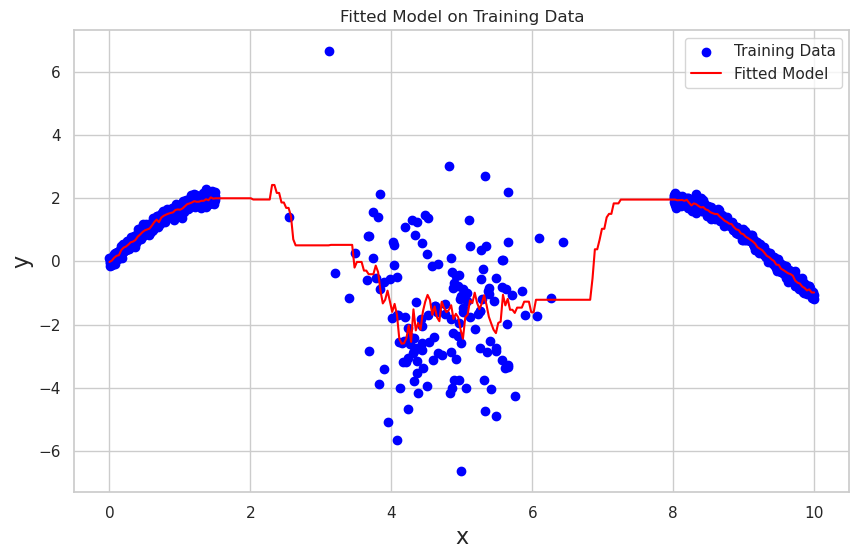

In [17]:
torch.manual_seed(45)
rng = np.random.default_rng(45)
alpha = 0.1
# considering 500 samples first
# Simulating samples
data_train = generate_data(1000, rng)
data_calibration = generate_data(1000, rng)
data_test = generate_data(1000, rng)

X_test = data_test["x"].to_numpy().reshape(-1, 1)
y_test = data_test["y"].to_numpy()

X_calib = data_calibration["x"].to_numpy().reshape(-1, 1)
y_calib = data_calibration["y"].to_numpy()

# gridding
x_grid = np.linspace(data_train["x"].min(), data_train["x"].max(), 300).reshape(-1, 1)

# fitting base model
X_train = data_train["x"].to_numpy().reshape(-1, 1)
y_train = data_train["y"].to_numpy()

model = KNeighborsRegressor(n_neighbors=10)
model.fit(X_train, y_train)

n_sample = 500

# Plotting the fitted model
plt.figure(figsize=(10, 6))
plt.scatter(data_train["x"], data_train["y"], color="blue", label="Training Data")
plt.plot(x_grid, model.predict(x_grid), color="red", label="Fitted Model")
plt.xlabel("x")
plt.ylabel("y")
plt.title("Fitted Model on Training Data")
plt.legend()
plt.show()

Fitting EPICSCORE:

In [ ]:
# fitting ECP, weighted, reg-split and mondrian
ecp_bart = ECP_split(
    RegressionScore,
    base_model=model,
    alpha=alpha,
    is_fitted=True,
)

ecp_bart.fit(X_train, y_train)
t_cutoff = ecp_bart.calib(
    X_calib,
    y_calib,
    epistemic_model="BART",
    random_seed_fit=rng,
    random_seed=42,
    m=100,
    var="heteroscedastic",
    N_samples_MC=500,
    type="gamma",
    normalize_y=False,
    n_cores = 6,
    progress = True,
)

Multiprocess sampling (4 chains in 4 jobs)
PGBART: [w]


Output()

Sampling 4 chains for 1_000 tune and 500 draw iterations (4_000 + 2_000 draws total) took 73 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Sampling: [w, y_pred]


Output()

0.9601933333333332

Fitting baselines:

In [19]:
# fitting reg-split
reg_split = RegressionSplit(model, alpha=alpha, is_fitted=True)

reg_split.fit(X_train, y_train)
reg_split.calibrate(X_calib, y_calib)

# fitting weighted regression split
w_reg_split = LocalRegressionSplit(
    base_model=model,
    alpha=alpha,
    is_fitted=True,
)

w_reg_split.fit(X_train, y_train)
w_reg_split.calibrate(X_calib, y_calib)

# fitting mondrian split
m_reg_split = MondrianRegressionSplit(
    base_model=model, alpha=alpha, is_fitted=True, k=10
)
m_reg_split.fit(X_train, y_train)
m_reg_split.calibrate(X_calib, y_calib)

In [20]:
# predicting in grid
pred_reg_split = reg_split.predict(x_grid)
pred_w_reg_split = w_reg_split.predict(x_grid)
pred_m_split = m_reg_split.predict(x_grid)
pred_ecp_bart = ecp_bart.predict(x_grid, random_seed=rng)

Sampling: [w, y_pred]


Output()

Plotting predictive intervals:

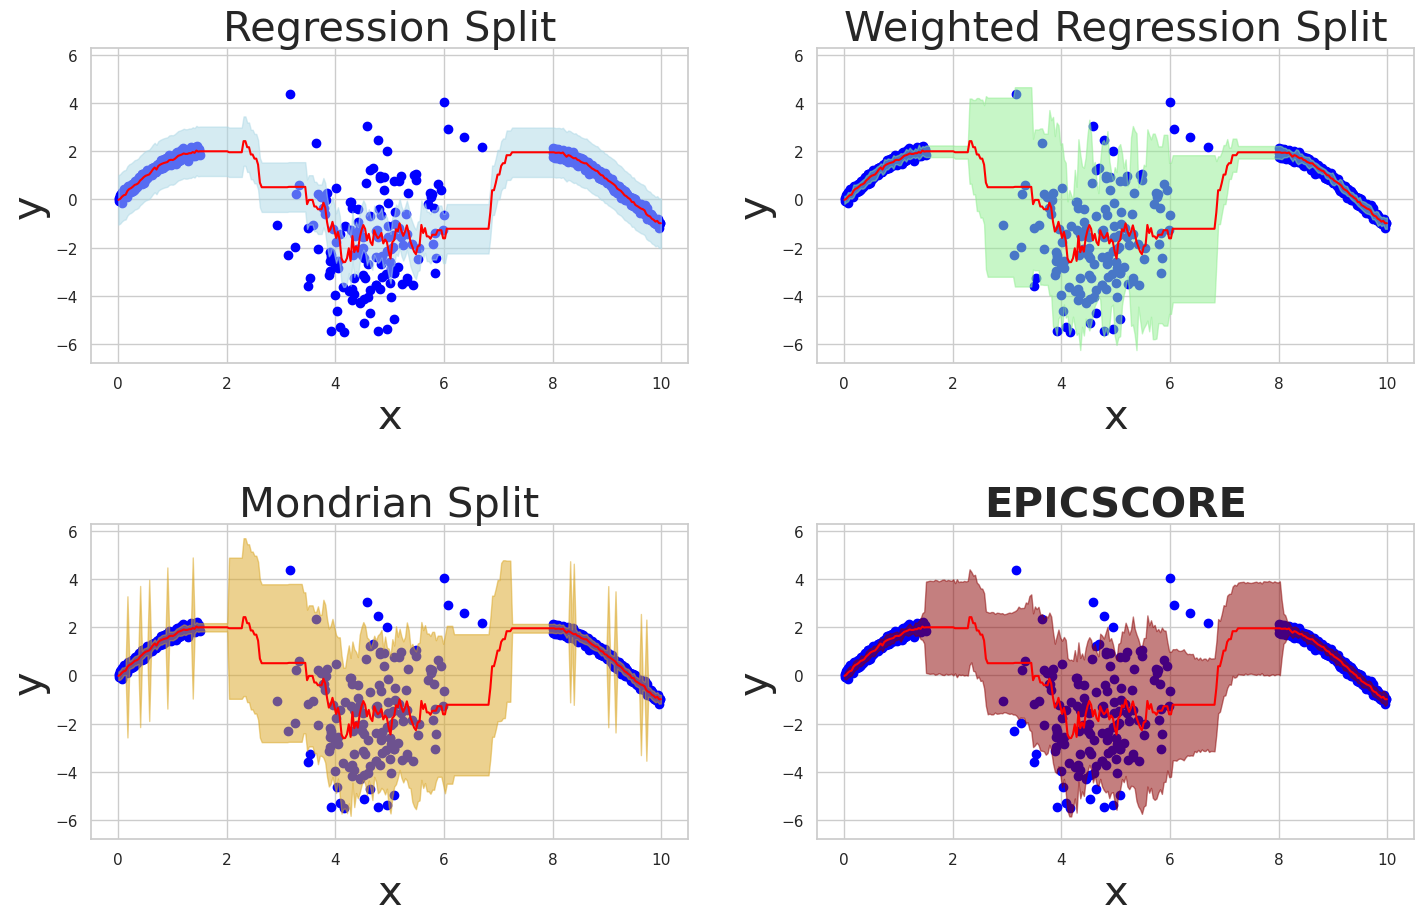

In [21]:
# Plotting prediction intervals
plt.rcParams.update({"font.size": 32})
fig, axs = plt.subplots(2, 2, figsize=(15, 10))

# Plot for Regression Split
axs[0, 0].scatter(data_test["x"], data_test["y"], color="blue", label="Training Data")
axs[0, 0].plot(x_grid, model.predict(x_grid), color="red")
axs[0, 0].fill_between(
    x_grid.ravel(),
    pred_reg_split[:, 0],
    pred_reg_split[:, 1],
    color="lightblue",
    alpha=0.5,
    label="Regression Split",
)
axs[0, 0].set_title("Regression Split")
axs[0, 0].set_xlabel("x")
axs[0, 0].set_ylabel("y")

# Plot for Weighted Regression Split
axs[0, 1].scatter(data_test["x"], data_test["y"], color="blue")
axs[0, 1].plot(x_grid, model.predict(x_grid), color="red")
axs[0, 1].fill_between(
    x_grid.ravel(),
    pred_w_reg_split[:, 0],
    pred_w_reg_split[:, 1],
    color="lightgreen",
    alpha=0.5,
    label="Weighted Regression Split",
)
axs[0, 1].set_title("Weighted Regression Split")
axs[0, 1].set_xlabel("x")
axs[0, 1].set_ylabel("y")

# Plot for Mondrian Split
axs[1, 0].scatter(data_test["x"], data_test["y"], color="blue")
axs[1, 0].plot(x_grid, model.predict(x_grid), color="red", label="Fitted Model")
axs[1, 0].fill_between(
    x_grid.ravel(),
    pred_m_split[:, 0],
    pred_m_split[:, 1],
    color="goldenrod",
    alpha=0.5,
    label="Mondrian Split",
)
axs[1, 0].set_title("Mondrian Split")
axs[1, 0].set_xlabel("x")
axs[1, 0].set_ylabel("y")

# Plot for ECP-MDN
axs[1, 1].scatter(data_test["x"], data_test["y"], color="blue")
axs[1, 1].plot(x_grid, model.predict(x_grid), color="red")
axs[1, 1].fill_between(
    x_grid.ravel(),
    pred_ecp_bart[:, 0],
    pred_ecp_bart[:, 1],
    color="darkred",
    alpha=0.5,
    label="EPIC",
)
axs[1, 1].set_title("EPICSCORE", fontweight="bold")
axs[1, 1].set_xlabel("x")
axs[1, 1].set_ylabel("y")
# Use the same y-axis scale for all plots
ylim = [
    min(ax.get_ylim()[0] for ax in axs.flat),
    max(ax.get_ylim()[1] for ax in axs.flat),
]
for ax in axs.flat:
    ax.set_ylim(ylim)
# Increase font size
for ax in axs.flat:
    ax.title.set_fontsize(30)
    ax.xaxis.label.set_fontsize(30)
    ax.yaxis.label.set_fontsize(30)
plt.tight_layout()
plt.show()